# Sentiment Analysis based on Embeddings

- This tutorial uses Sarkar's book example.
- Simple Multilayer Deep Neural Network on Sentiment Classification
- Use the average text embeddings based on word embeddings
- Use both self-trained word embeddings and spacy embeddings.

## Loading Packages

In [1]:
%%time

import pandas as pd
import numpy as np
import nltk
import gensim
import tensorflow
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dropout, Activation, Dense
from sklearn.preprocessing import LabelEncoder
from keras.layers.normalization import BatchNormalization

np.set_printoptions(precision=2, linewidth=80)


CPU times: user 4.91 s, sys: 1.33 s, total: 6.24 s
Wall time: 2min 4s


## Preparing Data

![](../images/text-tokenization-embedding.gif)

![](../images/text-tokenization-embedding.png)


- Important steps of text preprocessing for deep learning:
    - Text Preprocessing (normalization, enrichment, and/or tokenization)
    - Text to Sequences
    - Pad Sequences

### Importing Data into Python

In [2]:
## Loading the raw data and look at the structure of the data quickly
dataset = pd.read_csv('../../../RepositoryData/data/movie_reviews.csv')
# take a peek at the data
print(dataset.head())
reviews = np.array(dataset['review'])
sentiments = np.array(dataset['sentiment'])
type(reviews)
reviews.shape
sentiments.shape
# build train and test datasets
train_reviews = reviews[:35000]
train_sentiments = sentiments[:35000]
test_reviews = reviews[35000:]
test_sentiments = sentiments[35000:]

                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive


### Text Preprocessing

In [3]:
import TAWP
import re
from TAWP.contractions import CONTRACTION_MAP

def expand_contractions(text, contraction_mapping=CONTRACTION_MAP):
    ## create a regex pattern of all contracted forms
    contractions_pattern = re.compile('({})'.format('|'.join(
        contraction_mapping.keys())),
                                      flags=re.IGNORECASE | re.DOTALL)

    def expand_match(contraction):
        match = contraction.group(0)  # the whole matched contraction

        # if the matched contraction (=keys) exists in the dict,
        # get its corresponding uncontracted form (=values)
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())

        return expanded_contraction

    # find each contraction in the pattern,
    # find it from text,
    # and replace it using the output of
    # expand_match
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

In [4]:
def normalize(text):
    text = expand_contractions(text)
    text = re.sub(r'<.+?>',"", text)
    text = re.sub(r'\s+',' ', text)
    return text
    
normalize_corpus = np.vectorize(normalize)

In [5]:
print(train_reviews[101])

Okay, last night, August 18th, 2004, I had the distinct displeasure of meeting Mr. Van Bebble at a showing of the film The Manson Family at the Three Penny in Chicago as part of the Chicago Underground Film Festival. Here's what I have to say about it. First of all, the film is an obvious rip off of every Kenneth Anger, Roman Polanski, Oliver Stone and Terry Gilliam movie I've ever seen. Second of all, in a short Q & A session after the show Mr. Van Bebble immediately stated that he never made any contact with the actual Manson Family members or Charlie himself, calling them liars and saying he wanted nothing to do with them, that the film was based on his (Van Bebble's) take on the trial having seen it all from his living room on TV and in the news (and I'm assuming from the Autobiography and the book Helter Skelter which were directly mimicked through the narrative). So I had second dibs on questions, I asked if he was trying to present the outsider, Mtv, sex drugs and rock 'n roll v

In [6]:
print(normalize_corpus(train_reviews[1]))

A wonderful little production. The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great masters of comedy and his life. The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional dream techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwells murals decorating every surface) are terribly well done.


In [7]:
%%time
## Processing is ignored
norm_train_reviews = normalize_corpus(train_reviews)
norm_test_reviews = normalize_corpus(test_reviews)

CPU times: user 1min 43s, sys: 640 ms, total: 1min 43s
Wall time: 1min 44s


### Text Tokenization and One-Hot Encoding Labels

- In this tutorial, Sarkar did not convert texts into sequences because he directly converts words into embeddings, either using self-trained word embeddings (skipgram) or from spacy.

In [8]:
from nltk.tokenize.toktok import ToktokTokenizer

tokenizer = ToktokTokenizer()

- Tokenize texts into word tokens

In [9]:
# tokenize train reviews & encode train labels
tokenized_train = [tokenizer.tokenize(text)
                   for text in norm_train_reviews]

- One-hot encoding the class labels

In [10]:
le = LabelEncoder() ## label to sequences
num_classes=2 
y_tr = le.fit_transform(train_sentiments)
y_train = keras.utils.to_categorical(y_tr, num_classes) ## sequences to one-hot

print(y_tr[:5])
print(y_train[:5])

[1 1 1 0 1]
[[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [0. 1.]]


In [11]:
# tokenize test reviews & encode test labels
tokenized_test = [tokenizer.tokenize(text)
                   for text in norm_test_reviews]

y_ts = le.fit_transform(test_sentiments)
y_test = keras.utils.to_categorical(y_ts, num_classes)



# print class label encoding map and encoded labels
print('Sentiment class label map:', dict(zip(le.classes_, le.transform(le.classes_))))
print('Sample test label transformation:\n'+'-'*35,
      '\nActual Labels:', test_sentiments[:3], '\nEncoded Labels:', y_ts[:3], 
      '\nOne hot encoded Labels:\n', y_test[:3])

Sentiment class label map: {'negative': 0, 'positive': 1}
Sample test label transformation:
----------------------------------- 
Actual Labels: ['negative' 'positive' 'negative'] 
Encoded Labels: [0 1 0] 
One hot encoded Labels:
 [[1. 0.]
 [0. 1.]
 [1. 0.]]


## Descriptive Statistics

### Distribution of Text Lengths

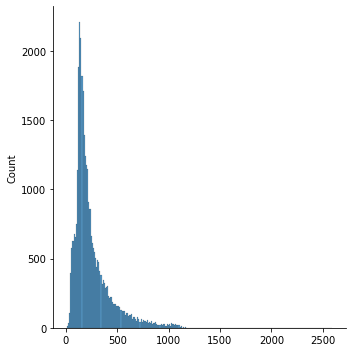

In [39]:
tokenized_train_len = [len(text) for text in tokenized_train]
import seaborn as sns
sns.displot(tokenized_train_len)

In [44]:
## min and max text lengths in training set
print(np.amin(tokenized_train_len))
print(np.amax(tokenized_train_len))

8
2594


## Training Word Embeddings

- Training the word embeddings using skip-gram on the training set
- Compute the average of embeddings for each document in the training and testing set

In [12]:
%%time
# build word2vec model
embed_dim = 96
w2v_model = gensim.models.Word2Vec(tokenized_train,
                                   size=embed_dim,
                                   window=5,
                                   max_vocab_size=20000,
                                   min_count=10,
                                   sample=1e-3,
                                   workers=4,
                                   sg=0)  # `sg=0` for BOW; `sg=1` for skipgram

## takes 5mins

CPU times: user 51.1 s, sys: 383 ms, total: 51.5 s
Wall time: 16.5 s


In [13]:
## This model uses the document word vector averaging scheme
## Use the average word vector representations to represent one document (movie reivew)

def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector
    
    # For each text in the corpus
    # Find the embeddings of each word in the corpus
    # and add all word vectors together and take the average
    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [14]:
%%time
# generate averaged word vector features from word2vec model
avg_wv_train_features = averaged_word2vec_vectorizer(corpus=tokenized_train, model=w2v_model,
                                                     num_features=embed_dim)
avg_wv_test_features = averaged_word2vec_vectorizer(corpus=tokenized_test, model=w2v_model,
                                                    num_features=embed_dim)

CPU times: user 50.9 s, sys: 870 ms, total: 51.8 s
Wall time: 51.2 s


## Loading Pre-trained Word Embeddings

- Load the GloVe embeddings from `spacy`. (The embedding dimension size of the small language model is 96).
- `spacy` computes the average embeddings for each document.

In [15]:
%%time
# Use the N-dimensional word vectors trained on the Common Crawl using the GloVe model
# Provided by spaCy

import spacy
#nlp = spacy.load('en', parse=False, tag=False, entity=False)
nlp_vec = spacy.load('en_core_web_sm', disable=['parser', 'tag','entity'])

CPU times: user 2.09 s, sys: 360 ms, total: 2.45 s
Wall time: 33.3 s


- spacy will automatically compute the average embeddings for the document.

In [16]:
doc =nlp_vec(str(norm_train_reviews[0]))
doc.vector

array([ 0.18,  0.04,  0.03, -0.11,  0.1 ,  0.11, -0.09,  0.09,  0.19, -0.28,
       -0.04, -0.  , -0.18, -0.08,  0.01,  0.04,  0.09, -0.17,  0.15,  0.  ,
       -0.12,  0.16,  0.08,  0.09, -0.3 , -0.02, -0.08,  0.22,  0.05,  0.25,
       -0.17,  0.01,  0.06, -0.27,  0.24, -0.06,  0.23, -0.07,  0.04,  0.17,
        0.01, -0.06, -0.01, -0.03, -0.02, -0.12,  0.1 ,  0.03, -0.07, -0.03,
        0.26,  0.02, -0.22, -0.17,  0.03,  0.15,  0.13,  0.04,  0.16,  0.14,
       -0.04, -0.2 , -0.06, -0.06,  0.1 , -0.09, -0.07, -0.19,  0.05,  0.15,
        0.19, -0.06,  0.04, -0.17, -0.17, -0.03, -0.15, -0.19, -0.09, -0.02,
       -0.03,  0.22,  0.16,  0.06, -0.07, -0.16, -0.14, -0.25, -0.15, -0.25,
       -0.16,  0.12,  0.18,  0.07,  0.14, -0.1 ], dtype=float32)

In [17]:
%%time

train_docs = nlp_vec.pipe([str(item) for item in norm_train_reviews], n_process=4)
train_glove_features = np.array([doc.vector for doc in train_docs])

CPU times: user 1min 58s, sys: 20.1 s, total: 2min 18s
Wall time: 5min 33s


In [18]:
%%time

test_docs = nlp_vec.pipe([str(item) for item in norm_test_reviews], n_process=4)
test_glove_features = np.array([doc.vector for doc in test_docs])

CPU times: user 49.2 s, sys: 15.9 s, total: 1min 5s
Wall time: 2min 26s


In [19]:
print('Word2Vec model:> Train features shape:', avg_wv_train_features.shape, ' Test features shape:', avg_wv_test_features.shape)
print('GloVe model:> Train features shape:', train_glove_features.shape, ' Test features shape:', test_glove_features.shape)

Word2Vec model:> Train features shape: (35000, 96)  Test features shape: (15000, 96)
GloVe model:> Train features shape: (35000, 96)  Test features shape: (15000, 96)


## Building Model

- A simple fully-connected 4 layer deep neural network
    - input layer (not counted as one layer), i.e., the word embedding layer
    - three dense hidden layers (with 512 neurons)
    - one output layer (with 2 neurons for classification)
- (aka. multi-layered perceptron or deep ANN)

In [20]:
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
# Plotting results
def plot(history):

    matplotlib.rcParams['figure.dpi'] = 100
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc)+1)
    ## Accuracy plot
    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    ## Loss plot
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

    
def plot2(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    #plt.gca().set_ylim(0,1)
    plt.show()

In [21]:
def construct_deepnn_architecture(num_input_features):
    dnn_model = Sequential()
    dnn_model.add(Dense(512, input_shape=(num_input_features,), kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization()) # improve  stability of the network.
    dnn_model.add(Activation('relu')) # relu better than sigmoid, to present vanishing gradient problem
    dnn_model.add(Dropout(0.2)) # prevents overfitting
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(512, kernel_initializer='glorot_uniform'))
    dnn_model.add(BatchNormalization())
    dnn_model.add(Activation('relu'))
    dnn_model.add(Dropout(0.2))
    
    dnn_model.add(Dense(2))
    dnn_model.add(Activation('softmax'))

    dnn_model.compile(loss='categorical_crossentropy', optimizer='adam',                 
                      metrics=['accuracy'])
    return dnn_model

In [22]:
w2v_dnn = construct_deepnn_architecture(num_input_features=embed_dim)

## Model Visualization

- To make this work, install `pip3 install pydot`
- and also install `!brew install graphviz` in terminal for mac
    - that is, install [graphvis](https://graphviz.gitlab.io/download/)


In [23]:
from keras.utils import plot_model

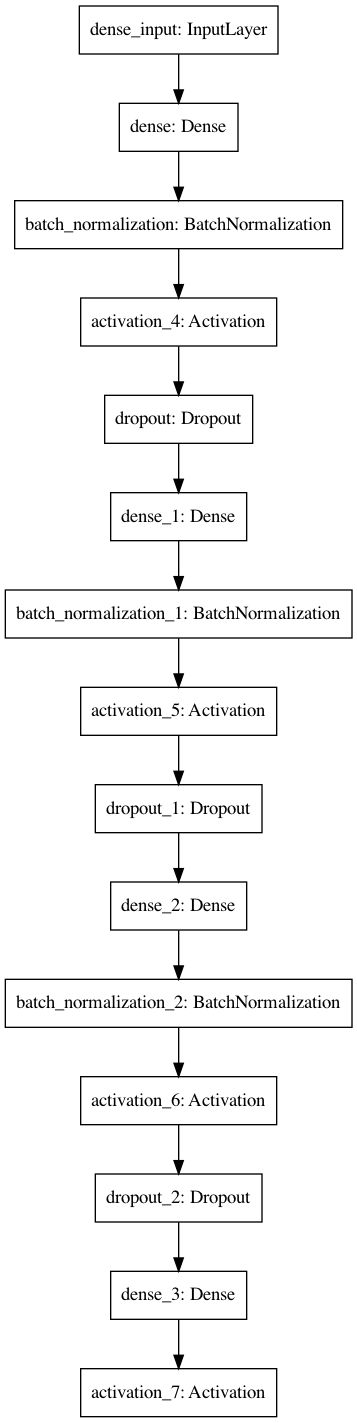

In [24]:
plot_model(w2v_dnn)

## Model Fitting

### Fitting using self-trained word embeddings

In [25]:
batch_size = 128
history =w2v_dnn.fit(avg_wv_train_features, y_train, epochs=10, batch_size=batch_size, 
            shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 6s 16ms/step - loss: 0.5310 - accuracy: 0.7601 - val_loss: 0.4303 - val_accuracy: 0.8103
Epoch 2/10
247/247 [==============================] - 3s 11ms/step - loss: 0.4003 - accuracy: 0.8199 - val_loss: 0.3790 - val_accuracy: 0.8229
Epoch 3/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3706 - accuracy: 0.8330 - val_loss: 0.3775 - val_accuracy: 0.8260
Epoch 4/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3712 - accuracy: 0.8335 - val_loss: 0.3672 - val_accuracy: 0.8317
Epoch 5/10
247/247 [==============================] - 2s 10ms/step - loss: 0.3590 - accuracy: 0.8451 - val_loss: 0.3851 - val_accuracy: 0.8266
Epoch 6/10
247/247 [==============================] - 3s 11ms/step - loss: 0.3546 - accuracy: 0.8450 - val_loss: 0.3919 - val_accuracy: 0.8209
Epoch 7/10
247/247 [==============================] - 3s 10ms/step - loss: 0.3561 - accuracy: 0.8451 - val_loss: 0.3896 - val_accuracy: 0.8214

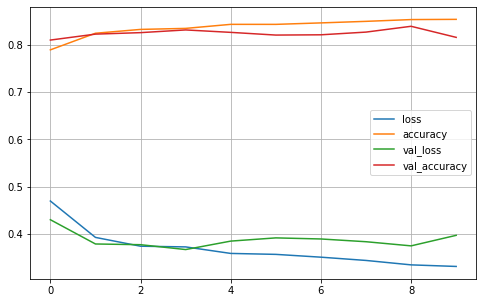

In [26]:
plot2(history)

In [27]:
y_pred = w2v_dnn.predict_classes(avg_wv_test_features)
predictions = le.inverse_transform(y_pred) 

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [28]:
# functions from Text Analytics with Python book
def get_metrics(true_labels, predicted_labels):
    
    print('Accuracy:', np.round(
                        metrics.accuracy_score(true_labels, 
                                               predicted_labels),
                        4))
    print('Precision:', np.round(
                        metrics.precision_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('Recall:', np.round(
                        metrics.recall_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))
    print('F1 Score:', np.round(
                        metrics.f1_score(true_labels, 
                                               predicted_labels,
                                               average='weighted'),
                        4))

def display_confusion_matrix(true_labels, predicted_labels, classes=[1,0]):
    
    total_classes = len(classes)
    level_labels = [total_classes*[0], list(range(total_classes))]

    cm = metrics.confusion_matrix(y_true=true_labels, y_pred=predicted_labels, 
                                  labels=classes)
    cm_frame = pd.DataFrame(data=cm, 
                            columns=pd.MultiIndex(levels=[['Predicted:'], classes], 
                                                  codes=level_labels), 
                            index=pd.MultiIndex(levels=[['Actual:'], classes], 
                                                codes=level_labels)) 
    print(cm_frame) 
def display_classification_report(true_labels, predicted_labels, classes=[1,0]):

    report = metrics.classification_report(y_true=true_labels, 
                                           y_pred=predicted_labels, 
                                           labels=classes) 
    print(report)
    
    
    
def display_model_performance_metrics(true_labels, predicted_labels, classes=[1,0]):
    print('Model Performance metrics:')
    print('-'*30)
    get_metrics(true_labels=true_labels, predicted_labels=predicted_labels)
    print('\nModel Classification report:')
    print('-'*30)
    display_classification_report(true_labels=true_labels, predicted_labels=predicted_labels, 
                                  classes=classes)
    print('\nPrediction Confusion Matrix:')
    print('-'*30)
    display_confusion_matrix(true_labels=true_labels, predicted_labels=predicted_labels, 
                             classes=classes)
from sklearn import metrics

In [29]:
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['negative', 'positive'])  

Model Performance metrics:
------------------------------
Accuracy: 0.8179
Precision: 0.8217
Recall: 0.8179
F1 Score: 0.8174

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.79      0.87      0.83      7490
    positive       0.86      0.76      0.81      7510

    accuracy                           0.82     15000
   macro avg       0.82      0.82      0.82     15000
weighted avg       0.82      0.82      0.82     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   negative positive
Actual: negative       6527      963
        positive       1768     5742


### Fitting using pre-trained word embedding model

In [30]:
glove_dnn = construct_deepnn_architecture(num_input_features=96)

In [31]:
batch_size = 128
history2=glove_dnn.fit(train_glove_features, y_train, epochs=10, batch_size=batch_size, 
              shuffle=True, validation_split=0.1, verbose=1)

Epoch 1/10
247/247 [==============================] - 4s 11ms/step - loss: 0.7195 - accuracy: 0.6264 - val_loss: 0.6452 - val_accuracy: 0.6037
Epoch 2/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5922 - accuracy: 0.6887 - val_loss: 0.5934 - val_accuracy: 0.6823
Epoch 3/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5674 - accuracy: 0.7103 - val_loss: 0.6008 - val_accuracy: 0.6854
Epoch 4/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5602 - accuracy: 0.7162 - val_loss: 0.5852 - val_accuracy: 0.6920
Epoch 5/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5524 - accuracy: 0.7216 - val_loss: 0.5895 - val_accuracy: 0.6831
Epoch 6/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5436 - accuracy: 0.7291 - val_loss: 0.5918 - val_accuracy: 0.6829
Epoch 7/10
247/247 [==============================] - 2s 10ms/step - loss: 0.5316 - accuracy: 0.7343 - val_loss: 0.5831 - val_accuracy: 0.6940

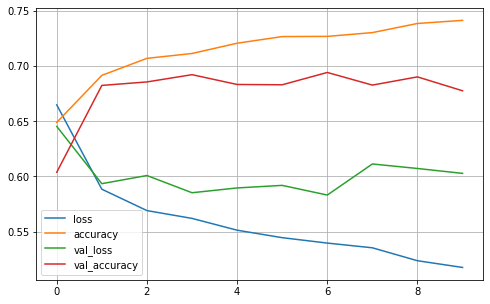

In [32]:
plot2(history2)

In [33]:
y_pred = glove_dnn.predict_classes(test_glove_features)
predictions = le.inverse_transform(y_pred) 

/Users/Alvin/opt/anaconda3/envs/python-notes/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [34]:
display_model_performance_metrics(true_labels=test_sentiments, predicted_labels=predictions, 
                                      classes=['negative', 'positive'])  

Model Performance metrics:
------------------------------
Accuracy: 0.6931
Precision: 0.6978
Recall: 0.6931
F1 Score: 0.6911

Model Classification report:
------------------------------
              precision    recall  f1-score   support

    negative       0.73      0.61      0.67      7490
    positive       0.67      0.77      0.72      7510

    accuracy                           0.69     15000
   macro avg       0.70      0.69      0.69     15000
weighted avg       0.70      0.69      0.69     15000


Prediction Confusion Matrix:
------------------------------
                 Predicted:         
                   negative positive
Actual: negative       4602     2888
        positive       1716     5794


## References

- [State of Arts on this dataset](https://paperswithcode.com/sota/sentiment-analysis-on-imdb)